## Predict and Evaluate the Trained Models on Independent Test Datasets ##

In [1]:
import numpy as np
import scipy.stats
import pandas as pd
import sklearn.metrics as metrics
import pickle
from gensim.models import word2vec
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.decomposition import PCA
from Metrics import *
from W2V_Seq_Embeddings import *

#### Configure Paths and Parameters

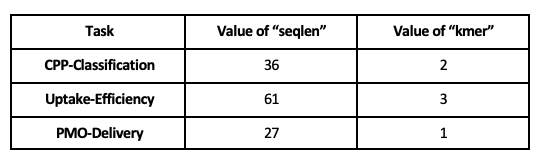

In [2]:
# seqlen: the value of the largest peptide in length between training sequences.

seqlen = 36  # CPP-Classification: 36, Uptake-Efficiency: 61, PMO-Delivery: 27

# kmer: Substring of length k contained within the amino acid sequences.
# Based on the task that is studied we provide an optimal value that arose after our experimentation.

kmer = 2  # CPP-Classification: 2, Uptake-Efficiency: 3, PMO-Delivery: 1

# Path of the selected Word2Vec model.
w2v_path = "/Users/stavroula/Downloads/CPP2Vec/Proposed Models/Word2Vec Models/W2V_CPP-Classification.pt"

# Path of the proposed trained model.
ml_path = "/Users/stavroula/Downloads/CPP2Vec/Proposed Models/ML Models/ML_CPP-Classification.asv"

# Test dataset in .csv format.
test_file = "/Users/stavroula/Downloads/CPP2Vec/Data/Test Datasets/KELM-CPPpred.csv"

#### Generate Embeddings for the Amino Acid Sequences

In [4]:
# Load Word2Vec and Machine Learning models.
w2v_model = word2vec.Word2Vec.load(w2v_path)
ml_model = pickle.load(open(ml_path, 'rb'))

# Trimming and padding all the sequences of the test dataset.
test_dataset = seq_balance(test_file, seqlen, index_col=None)
test_seq = test_dataset['seq'].tolist()

# Generate the embeddings of the test dataset.
test_X = w2v_emb_gen(test_seq, w2v_model, kmer)
test_y = test_dataset['label'].to_numpy()

#### Save Probability Estimates per Sequence

In [5]:
# Dataframe to save ground truth and predicted probabilities per sequence.
test_result = np.zeros((len(test_y), 2))
test_result[:, 1] = test_dataset['label01'].to_numpy()
test_result[:, 0] = ml_model.predict_proba(test_X)[:, 1]

test_output = pd.DataFrame(test_result, columns=['prob', 'label'])
test_output.to_csv('/Users/stavroula/Downloads/CPP2Vec/Results/probabilities.csv') #Results/probabilities.csv

### Metrics Calculation ###

In [6]:
# Ground truth values
y_true = test_dataset['label01'].to_numpy()
# Probability estimates
y_prob = ml_model.predict_proba(test_X)[:, 1]

# Calculate and save evaluation metrics
data = {'Metric': ['Sensitivity', 'Specificity', 'Accuracy', 'AUC', 'MCC', 'Precision', 'Recall', 'F1-Score', 'AUPRC'], 
        'Value': [sensitivity(y_true, y_prob), specificity(y_true, y_prob), accuracy(y_true, y_prob), AUC(y_true, y_prob), MCC(y_true, y_prob), precision(y_true, y_prob), recall(y_true, y_prob), f1(y_true, y_prob), AUPRC(y_true, y_prob)]} 
 
df = pd.DataFrame(data) 

df.style.hide(axis="index")

Metric,Value
Sensitivity,0.614583
Specificity,0.958333
Accuracy,0.786458
AUC,0.879774
MCC,0.610095
Precision,0.936508
Recall,0.614583
F1-Score,0.742138
AUPRC,0.896686


### Principal Component Analysis ###

In [7]:
df_in = pd.DataFrame(test_X)
dflabel = pd.DataFrame(test_y)

pca = PCA(n_components=2)

principalComponents = pca.fit_transform(df_in)

df_hlp = pd.DataFrame(data = principalComponents
             , columns = ['Principal Component 1', 'Principal Component 2'])

df_pca = pd.concat([df_hlp, dflabel], axis = 1)

#### Plot PCA Figures

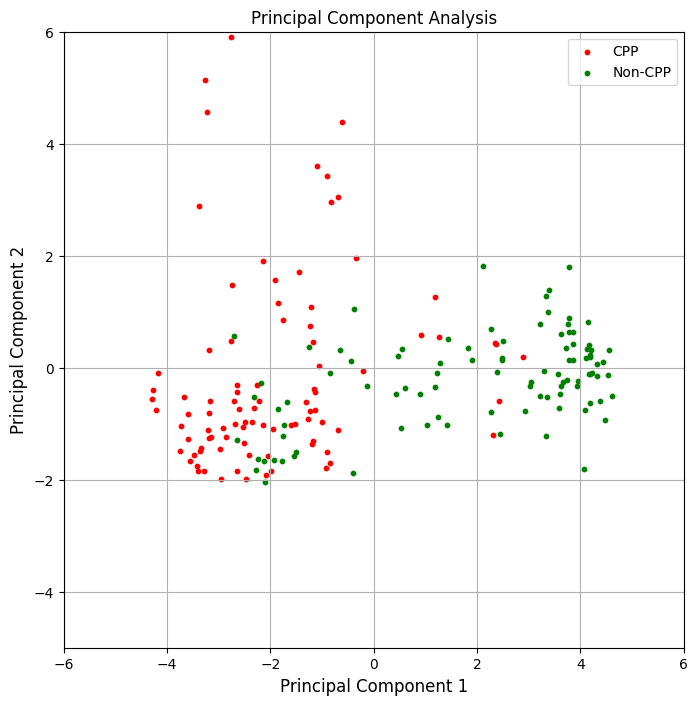

In [8]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 12)
ax.set_ylabel('Principal Component 2', fontsize = 12)
ax.set_title('Principal Component Analysis', fontsize = 12)

# For CPP-Classification: targets = ['CPP', 'Non-CPP']
# For Uptake-Efficiency: targets = ['High','Low']
# For PMO-Delivery: targets = ['≥ 3-fold', '< 3-fold']

targets = ['CPP', 'Non-CPP']
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = df_pca[0] == target
    ax.scatter(df_pca.loc[indicesToKeep, 'Principal Component 1'], df_pca.loc[indicesToKeep, 'Principal Component 2'], c = color, s = 10)

ax.legend(targets)
ax.grid()
plt.xlim(-6, 6)
plt.ylim(-5, 6)
plt.savefig('/Users/stavroula/Downloads/CPP2Vec/Results/Principal Component Analysis Plots/pca.png')